In [239]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import math

In [240]:
font1 = {'family': 'Times New Roman',
             'weight': 'normal',
             'size': 15,
             }

df = pd.read_csv("../output/COVID_final.csv")
df = df[~df['id'].isin(['371200', '710000', '810000'])] # 去除台湾，香港和莱芜

kf = KFold(3, True)
index = []
for train_index, test_index in kf.split(df):
    index.append((train_index, test_index))

In [241]:
# feature importance 特征重要性
def feture_importance(features, indices, importances):
    print("%%%%%% feature importances %%%%%%")
    plt.barh(range(len(indices)), importances[indices], color='b', align='center', alpha=0.5)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('feature Importance')
    plt.show()
    
# 评价指标
def evaluation(real_y, prediction_y):

    # rmse  mae r2
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(real_y, prediction_y)
    print("R-squared", r_value**2)
    print("R", r_value)

    mae = mean_absolute_error(real_y, prediction_y)
    print("mae", mae)

    rmse = mean_squared_error(real_y, prediction_y) ** 0.5
    print("rmse", rmse)


    figsize = 20,16
    figure, ax = plt.subplots(figsize=figsize)
    
    level = [50000, 5500, 1000, 200, 100, 80, 60, 40,20]
    
    for i in range(len(level)):
        plt.subplot(3,3,i+1)
        plt.scatter(real_y, prediction_y, c='b', marker='o', label='', s=10, alpha=0.7, zorder=20)
        plt.plot([0, 50000], [0, 50000], '--', color='black', label='', linewidth=1.0)
        plt.xlim(0, level[i])
        plt.ylim(0, level[i])
        plt.tick_params(labelsize=15)
        plt.ylabel('prediction', font1)
        plt.xlabel('real', font1)
        ax = plt.gca()
        ax.set_aspect(1)
    plt.show()

In [242]:
def covid_all_predict(df, index):

    real_y = []
    prediction_y = []

    clf = [RandomForestRegressor(n_estimators=6, min_samples_split=5, max_depth=5),
           RandomForestRegressor(n_estimators=6, min_samples_split=5, max_depth=5),
           RandomForestRegressor(n_estimators=6, min_samples_split=5, max_depth=5)]
    
    case = []
    ids = []
    for i in range(len(index)):

        train_df = df.iloc[index[i][0], :]
        test_df = df.iloc[index[i][1], :]
        
        ids.extend(test_df['id'].to_list())

        train_y_log = train_df['confirmed_log']
        train_y = train_df['confirmed']

        train_x = train_df.drop(['id', 'location', 'confirmed_log', 'confirmed', 'cured', 'dead'], axis=1)

        test_y = test_df['confirmed']
        test_x = test_df.drop(['id', 'location', 'confirmed_log', 'confirmed', 'cured', 'dead'], axis=1)

        clf[i].fit(train_x, train_y_log)

        predict_ytrain_log = clf[i].predict(train_x)
        predict_ytrain = np.trunc(np.exp(predict_ytrain_log) - 1)

        predict_ytest_log = clf[i].predict(test_x)
        predict_ytest = np.trunc(np.exp(predict_ytest_log) - 1)

        real_y.extend(test_y)
        prediction_y.extend(predict_ytest)

        print("train fold " + str(i+1))
        predict_train_y = list(predict_ytrain)
        
        threshold = 50
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        
        train_yy = train_y.to_list()
        for j in range(len(train_df)):
            if abs(train_yy[j]-predict_train_y[j])>threshold:
                print(train_df.iloc[j, 1] + "   real: " + str(train_yy[j]) + "   pre:" + str(predict_train_y[j]))
                case.append(train_df.iloc[j, 0])
        evaluation(train_y, predict_train_y)
                
        print("#########################################")

        print("test fold " + str(i+1))
        predict_y = list(predict_ytest)
        print("预测误差较大城市，绝对值误差阈值设置为" + str(threshold))
        test_yy = test_y.to_list()
        for j in range(len(test_df)):
            if abs(test_yy[j]-predict_y[j])>threshold:
                print(test_df.iloc[j, 1] + "   real: " + str(test_yy[j]) + "   pre:" + str(predict_y[j]))
                case.append(test_df.iloc[j, 0])
        evaluation(test_y, predict_y)
        
        print("                             ")
    
    
    ids = pd.DataFrame(ids)
    ids.columns = ['id']
    ids['predict'] = prediction_y

    print("************* cv evaluation ***************")
    evaluation(real_y, prediction_y)

    # feature importance
    train_y = df['confirmed']
    #train_y = df['confirmed_before']
    #train_y = df['confirmed_after']
    # train_y = train_df['dead']
    train_x = df.drop(['id', 'location', 'confirmed_log', 'cured', 'dead', 'confirmed'], axis=1)
    #train_x = df.drop(['id', 'location', 'confirmed_before', 'cured_before', 'dead_before'], axis=1)
    #train_x = df.drop(['id', 'location', 'confirmed_after', 'cured_after', 'dead_after'], axis=1)


    clf = RandomForestRegressor(n_estimators=6, min_samples_split=5, max_depth=5)
    clf.fit(train_x, train_y)
    print("%%%%%%%%%%%%% all sample model %%%%%%%%%%%%%%")
    #evaluation(train_y, clf.predict(train_x))
    features = list(train_x)
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    feture_importance(features, indices, importances)
    
    return case, ids


In [243]:
# 随机森林建模疫情——全国城市，确诊人数经过log处理，得到预测值之后做exp转换，我做了取整操作，然后计算评价指标
# 设置绝对值误差阈值为100，筛选出那些预测较差的城市
# 高值城市预测较差，比如湖北那些城市，但是也会出现一些确诊人数为0-5城市预测达到几千甚至几万

/Users/shaoqi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/shaoqi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


train fold 1
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:236.0
天津市   real: 174   pre:94.0
哈尔滨市   real: 198   pre:62.0
宁波市   real: 157   pre:76.0
温州市   real: 504   pre:228.0
台州市   real: 146   pre:62.0
亳州市   real: 108   pre:57.0
南昌市   real: 230   pre:162.0
上饶市   real: 123   pre:53.0
济宁市   real: 260   pre:55.0
武汉市   real: 50006   pre:17223.0
襄阳市   real: 1175   pre:1253.0
荆州市   real: 1580   pre:1261.0
咸宁市   real: 836   pre:1172.0
随州市   real: 1307   pre:803.0
仙桃市   real: 575   pre:730.0
潜江市   real: 198   pre:280.0
天门市   real: 496   pre:336.0
甘孜藏族自治州   real: 78   pre:17.0
贵阳市   real: 36   pre:128.0
R-squared 0.989622767486008
R 0.9947978525740835
mae 156.2375
rmse 2116.978606607382


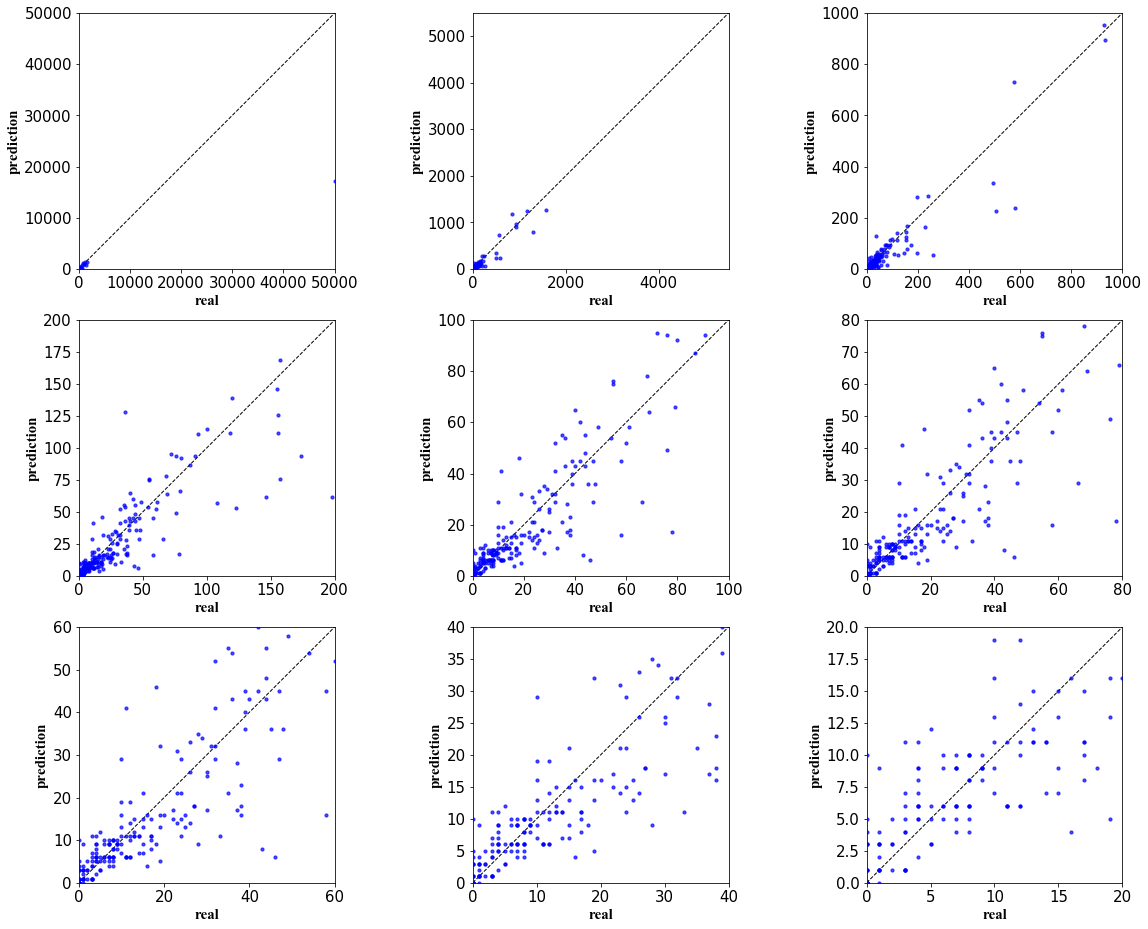

#########################################
test fold 1
预测误差较大城市，绝对值误差阈值设置为50
上海市   real: 516   pre:117.0
杭州市   real: 181   pre:92.0
合肥市   real: 174   pre:95.0
蚌埠市   real: 160   pre:18.0
阜阳市   real: 155   pre:94.0
新余市   real: 130   pre:7.0
信阳市   real: 274   pre:176.0
黄石市   real: 1015   pre:1261.0
鄂州市   real: 1394   pre:4520.0
孝感市   real: 3518   pre:1261.0
黄冈市   real: 2907   pre:1172.0
恩施土家族苗族自治州   real: 252   pre:657.0
广州市   real: 435   pre:150.0
深圳市   real: 450   pre:150.0
海口市   real: 39   pre:90.0
重庆市   real: 579   pre:274.0
昆明市   real: 53   pre:139.0
R-squared 0.3800409610764999
R 0.6164746232218321
mae 89.98347107438016
rmse 392.3239300829131


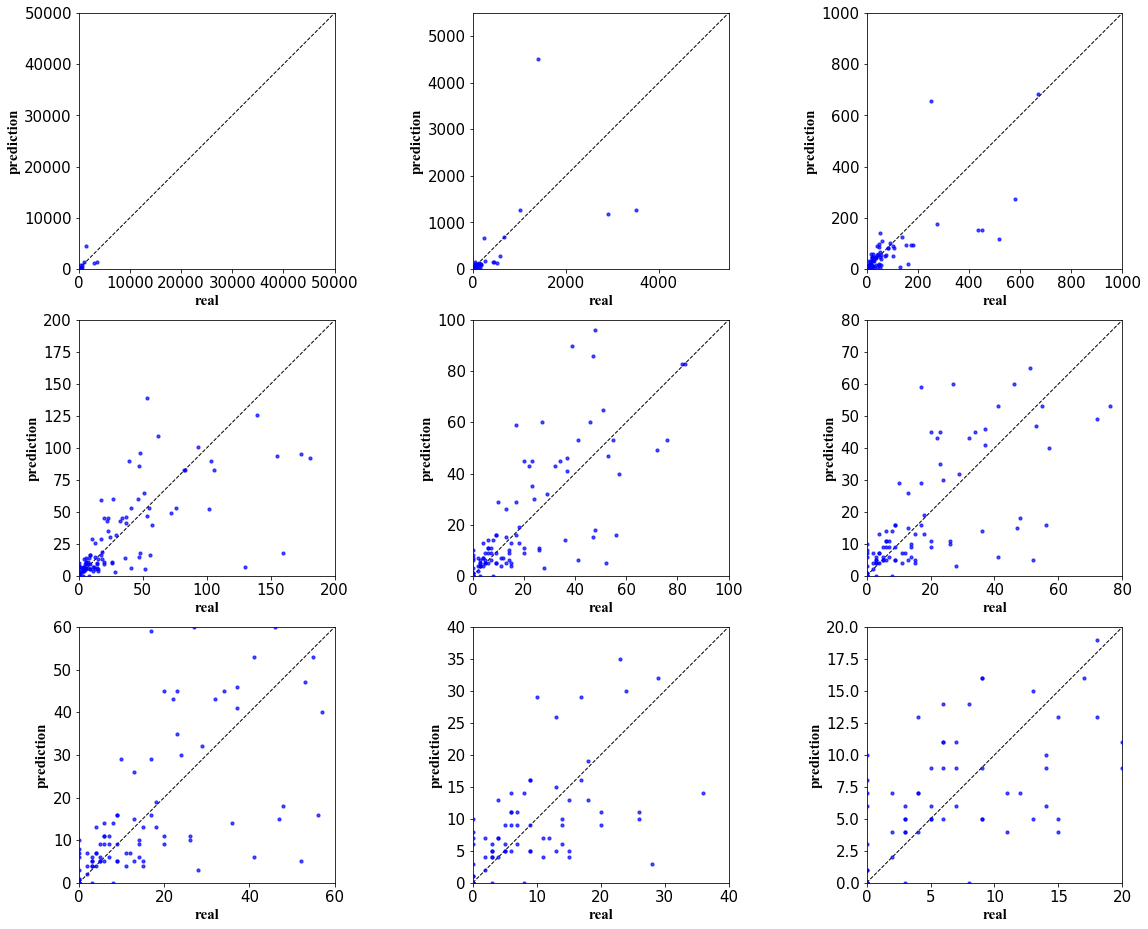

                             
train fold 2
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:117.0
上海市   real: 516   pre:439.0
宁波市   real: 157   pre:100.0
温州市   real: 504   pre:221.0
台州市   real: 146   pre:69.0
蚌埠市   real: 160   pre:51.0
阜阳市   real: 155   pre:104.0
新余市   real: 130   pre:17.0
上饶市   real: 123   pre:60.0
郑州市   real: 157   pre:221.0
黄石市   real: 1015   pre:1496.0
十堰市   real: 672   pre:364.0
襄阳市   real: 1175   pre:1496.0
鄂州市   real: 1394   pre:1496.0
孝感市   real: 3518   pre:2087.0
黄冈市   real: 2907   pre:2087.0
随州市   real: 1307   pre:677.0
恩施土家族苗族自治州   real: 252   pre:368.0
广州市   real: 435   pre:320.0
重庆市   real: 579   pre:463.0
甘孜藏族自治州   real: 78   pre:14.0
R-squared 0.8966195912607001
R 0.9468999901049213
mae 30.16597510373444
rmse 125.07139869604174


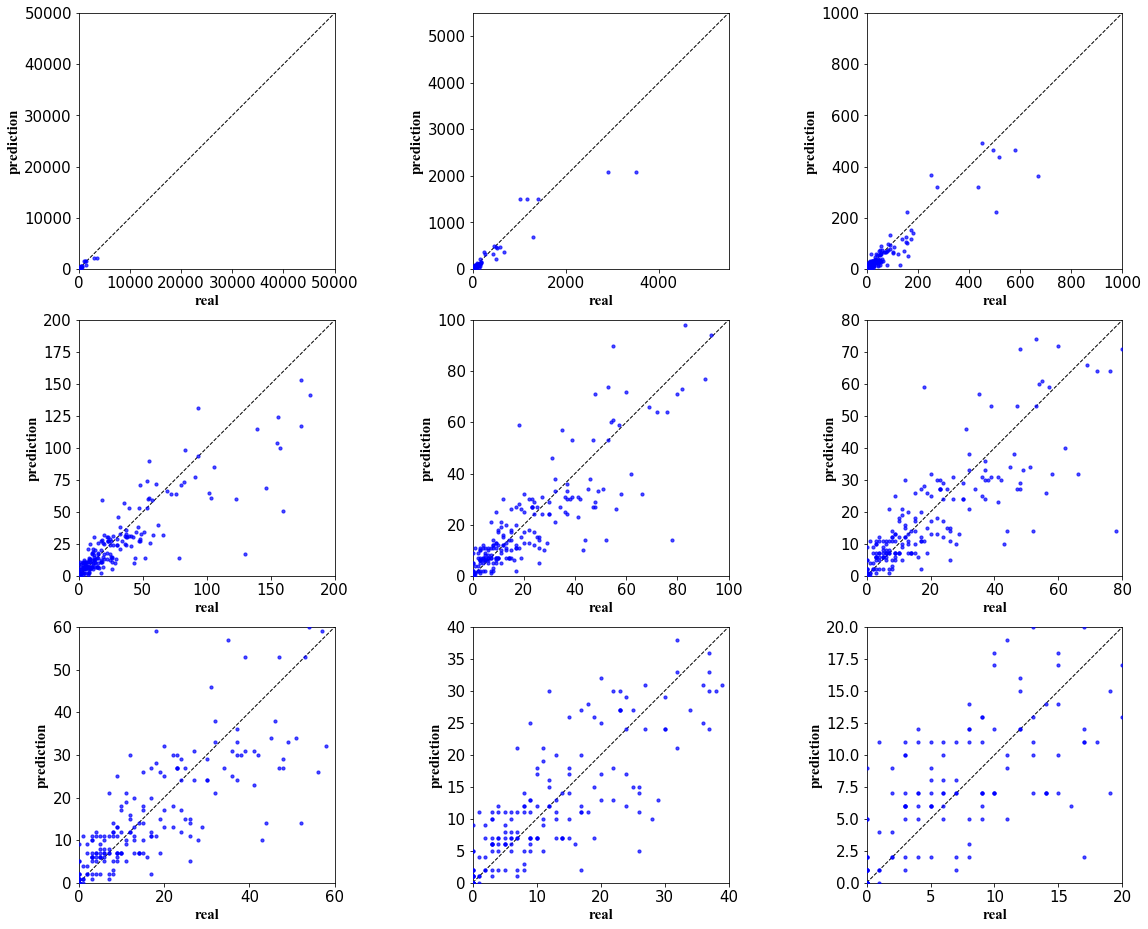

#########################################
test fold 2
预测误差较大城市，绝对值误差阈值设置为50
北京市   real: 580   pre:285.0
哈尔滨市   real: 198   pre:78.0
亳州市   real: 108   pre:26.0
南昌市   real: 230   pre:136.0
济宁市   real: 260   pre:32.0
武汉市   real: 50006   pre:2087.0
宜昌市   real: 931   pre:1496.0
荆门市   real: 928   pre:769.0
荆州市   real: 1580   pre:1774.0
咸宁市   real: 836   pre:1496.0
仙桃市   real: 575   pre:769.0
潜江市   real: 198   pre:463.0
长沙市   real: 242   pre:491.0
东莞市   real: 100   pre:161.0
西安市   real: 120   pre:228.0
R-squared 0.355213232699416
R 0.5959976784345858
mae 434.5833333333333
rmse 4375.520231926714


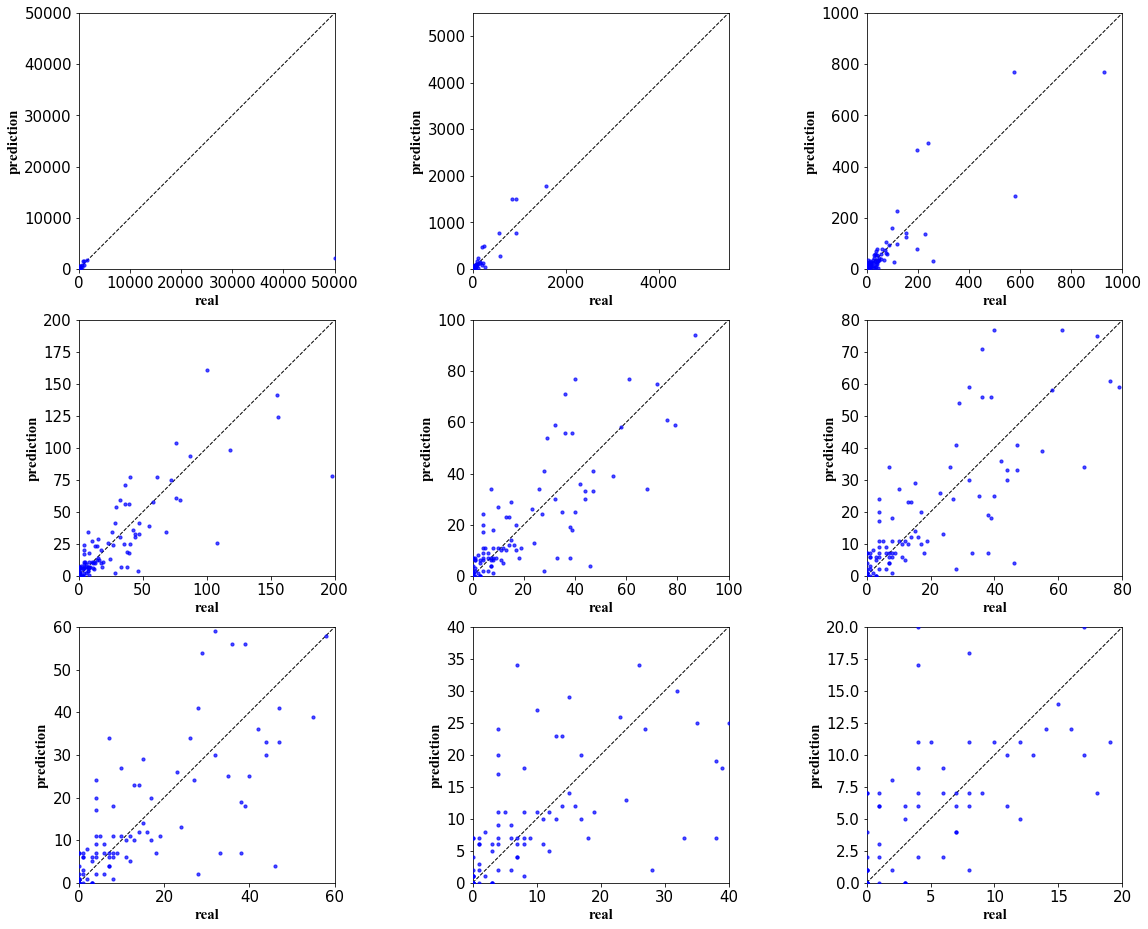

                             
train fold 3
预测误差较大城市，绝对值误差阈值设置为50
哈尔滨市   real: 198   pre:86.0
上海市   real: 516   pre:439.0
蚌埠市   real: 160   pre:28.0
亳州市   real: 108   pre:50.0
南昌市   real: 230   pre:173.0
新余市   real: 130   pre:9.0
济宁市   real: 260   pre:111.0
南阳市   real: 156   pre:214.0
信阳市   real: 274   pre:331.0
武汉市   real: 50006   pre:4661.0
黄石市   real: 1015   pre:860.0
十堰市   real: 672   pre:506.0
宜昌市   real: 931   pre:860.0
鄂州市   real: 1394   pre:860.0
荆门市   real: 928   pre:860.0
孝感市   real: 3518   pre:2947.0
荆州市   real: 1580   pre:1933.0
潜江市   real: 198   pre:262.0
长沙市   real: 242   pre:337.0
邵阳市   real: 102   pre:50.0
重庆市   real: 579   pre:442.0
R-squared 0.5588475852946947
R 0.747561091346182
mae 208.4688796680498
rmse 2921.6063967891596


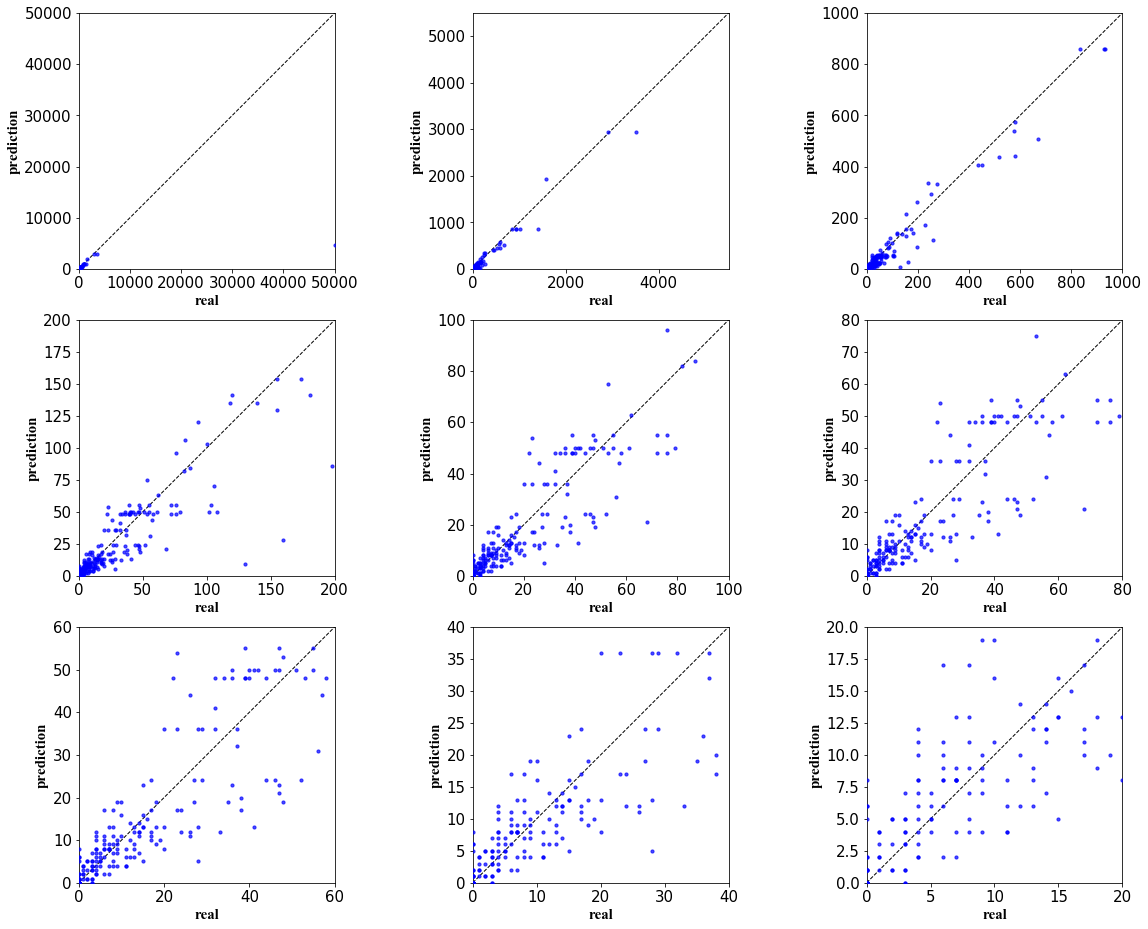

#########################################
test fold 3
预测误差较大城市，绝对值误差阈值设置为50
天津市   real: 174   pre:36.0
宁波市   real: 157   pre:50.0
温州市   real: 504   pre:57.0
台州市   real: 146   pre:44.0
上饶市   real: 123   pre:50.0
郑州市   real: 157   pre:406.0
焦作市   real: 32   pre:83.0
襄阳市   real: 1175   pre:1046.0
随州市   real: 1307   pre:540.0
南充市   real: 39   pre:111.0
甘孜藏族自治州   real: 78   pre:12.0
R-squared 0.7653602640978006
R 0.8748487092622361
mae 26.925
rmse 88.82046498414653


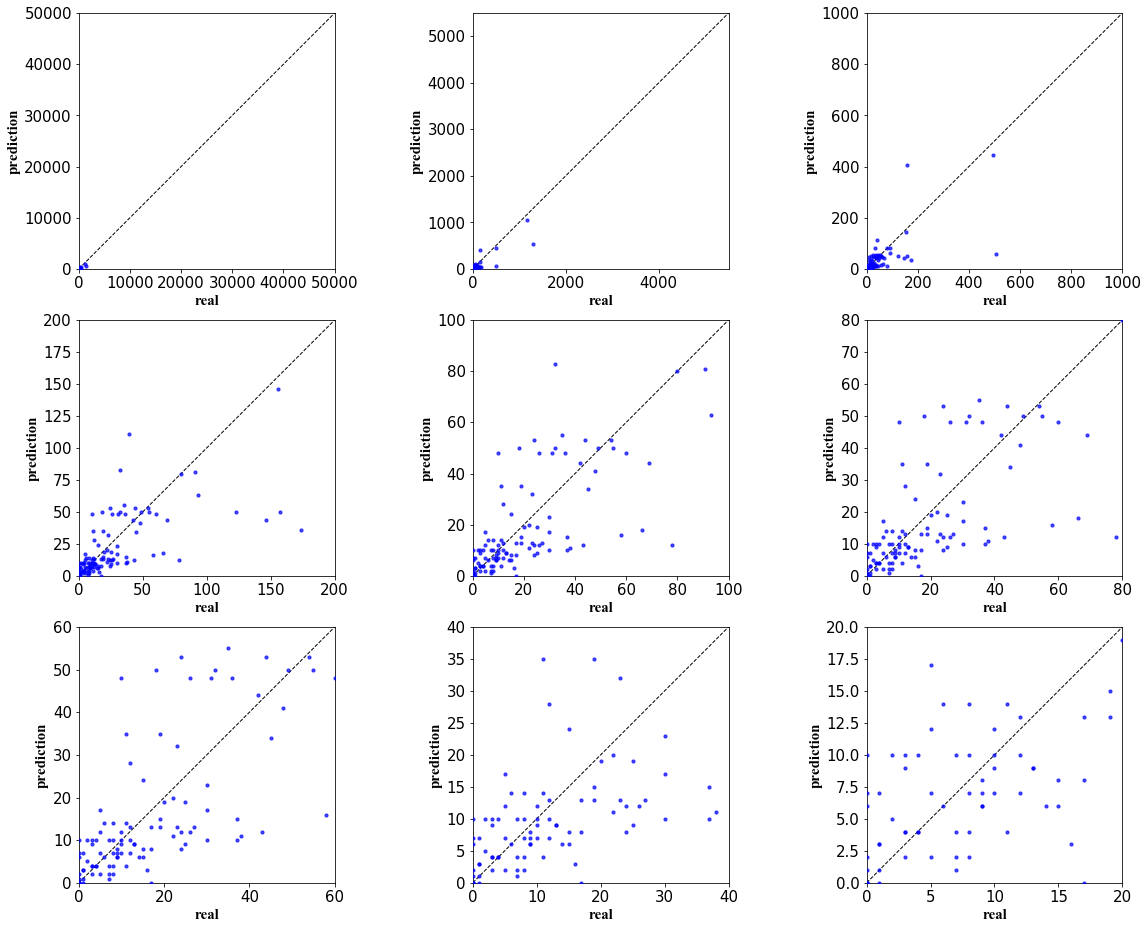

                             
************* cv evaluation ***************
R-squared 0.15406098904796808
R 0.3925060369573544
mae 183.57063711911357
rmse 2533.42861140508


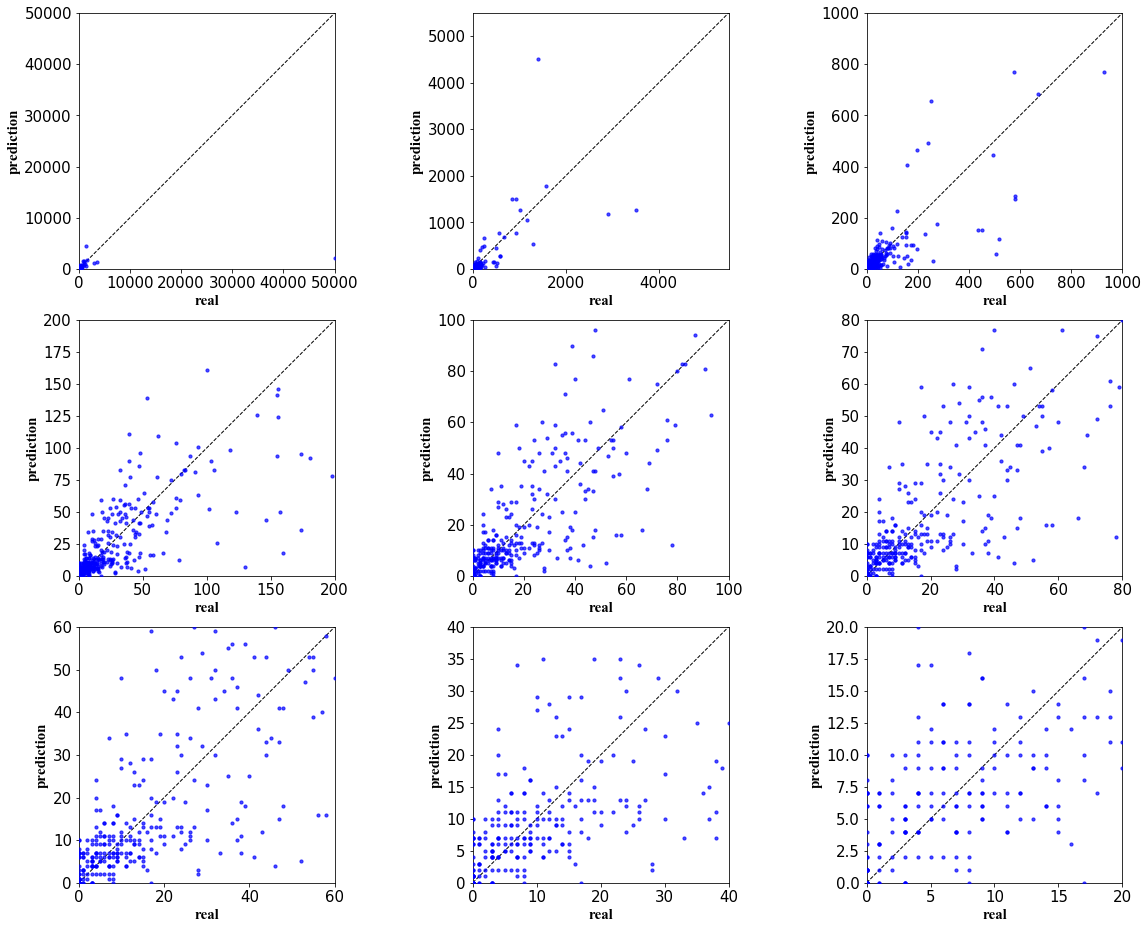

%%%%%%%%%%%%% all sample model %%%%%%%%%%%%%%
%%%%%% feature importances %%%%%%


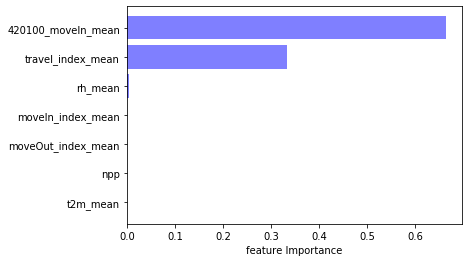

In [244]:
'''
'id', 'location','rh_mean', 'rh_max', 'rh_min', 't2m_mean', 't2m_max', 't2m_min',
         'confirmed', 'cured', 'dead',
         'moveIn_index_mean', 'moveIn_index_max', 'moveIn_index_min',
         'moveOut_index_mean', 'moveOut_index_max', 'moveOut_index_min',
         'travel_index_mean', 'travel_index_max', 'travel_index_min',
         '420100_moveIn_mean', '420100_moveIn_max', '420100_moveIn_min', 'npp'
'''

df1 = df[['id', 'location','rh_mean', 't2m_mean',
         'confirmed', 'cured', 'dead',
         'moveIn_index_mean', 
         'moveOut_index_mean', 
         'travel_index_mean', 
         '420100_moveIn_mean', 'npp']]
confirmed = df1['confirmed'].to_list()
confirmed = [math.log(i+1) for i in confirmed]
df1.loc[:, 'confirmed_log'] = confirmed
case, ids = covid_all_predict(df1, index)

In [248]:
df1 = pd.merge(df, ids, how='inner', on='id')
df1 = df1[['id', 'location', 'confirmed', 'predict', 'rh_mean', 't2m_mean',
         'moveIn_index_mean', 
         'moveOut_index_mean', 
         'travel_index_mean', 
         '420100_moveIn_mean', 'npp']]
df1[df1['id'].isin(case)].sort_values(by='confirmed', ascending=False)

,id,location,confirmed,predict,rh_mean,t2m_mean,moveIn_index_mean,moveOut_index_mean,travel_index_mean,420100_moveIn_mean,npp
167,420100,武汉市,50006,2087.0,71.641574,282.450565,1.441894,2.023355,1.722975,100.000000,6.210740
174,420900,孝感市,3518,1261.0,71.220821,281.658520,0.581259,0.472132,2.987432,13.913226,0.946868
176,421100,黄冈市,2907,1172.0,73.670450,281.820969,0.785669,0.582993,3.386525,13.977419,0.613669
175,421000,荆州市,1580,1774.0,72.451254,282.582504,0.692491,0.586977,3.262016,6.220968,0.725221
172,420700,鄂州市,1394,4520.0,73.019245,283.017837,0.230197,0.226363,2.240659,4.588065,2.442400
178,421300,随州市,1307,540.0,70.869639,281.006504,0.238099,0.192810,2.924918,2.761613,0.398786
171,420600,襄阳市,1175,1046.0,71.089229,280.628471,0.499872,0.428895,3.136352,3.758387,0.592567
168,420200,黄石市,1015,1261.0,75.266181,282.757838,0.349638,0.311960,3.025581,3.639032,1.274760
170,420500,宜昌市,931,1496.0,77.009034,280.014196,0.421915,0.356423,3.151497,3.186774,0.593338
173,420800,荆门市,928,769.0,71.564911,281.839559,0.321647,0.279806,3.208329,3.030000,0.498180


In [247]:
# 阿里地区、五家渠市和香港地区，与湖北等城市对比来看，香港与随州在很多特征上相似，但是武汉迁入香港的比例为0，武汉迁入随州并不为0
# 百度平台只发布前100名，所以如果不在100名内，比例应该是可以视为0的
# 确诊人数为0的城市与这些城市对比来看，香港的夜光很高，五家渠和果洛藏族自治州的特征较为相似，不过五家渠的迁徙指数会稍高一些
# 或许还是像特征分析里的那样，许多确诊人数相近的城市，特征差异较大，上面37个确诊人数为0的城市，特征差异较大，相对湿度和气温跨度较大，导致模型学不好？？？
# 另外，不仅仅是阿里地区、五家渠市和香港地区，有的时候会会变成其他一些低值城市

In [352]:
# 随机森林建模疫情——全国城市，确诊人数做log处理，label范围被压缩的小很多，精度也提高很多
# 低值城市预测的结果几乎与y轴平行，误差较大
# 或许还是像特征分析里的那样，许多确诊人数相近的城市，特征差异较大，上面37个确诊人数为0的城市，特征差异较大，相对湿度和气温跨度较大，导致模型学

In [356]:
# 管控前疫情分析

In [362]:
df = pd.read_csv("../output/COVID_final.csv")

df2 = df[['id','location','npp',
         'rh_mean_before','rh_max_before','rh_min_before',
         't2m_mean_before','t2m_max_before','t2m_min_before',
         'moveIn_index_mean_before','moveIn_index_max_before',
         'moveIn_index_min_before','moveOut_index_mean_before',
         'moveOut_index_max_before','moveOut_index_min_before',
         'travel_index_mean_before','travel_index_max_before',
         'travel_index_min_before','420100_moveIn_mean_before',
         '420100_moveIn_max_before','420100_moveIn_min_before']]

confirmed = df['confirmed_before'].to_list()
confirmed = [math.log(i+1) for i in confirmed]
df2.loc[:, 'confirmed'] = confirmed
df2 = df2[~df2['id'].isin(['371200', '710000'])] # 去除台湾和莱芜
df2

/Users/shaoqi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/shaoqi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,location,npp,rh_mean_before,rh_max_before,rh_min_before,t2m_mean_before,t2m_max_before,t2m_min_before,moveIn_index_mean_before,...,moveOut_index_mean_before,moveOut_index_max_before,moveOut_index_min_before,travel_index_mean_before,travel_index_max_before,travel_index_min_before,420100_moveIn_mean_before,420100_moveIn_max_before,420100_moveIn_min_before,confirmed
0,110000,北京市,6.25382,46.565638,74.023287,34.093583,267.464901,271.101167,263.053292,8.566340,...,14.056416,23.914472,6.335561,5.289280,6.6375,1.8254,1.179615,2.21,0.36,4.234107
1,120000,天津市,7.12393,45.797824,79.905796,25.327988,270.778598,273.341750,267.294000,3.200709,...,5.085501,7.012818,2.520493,5.325788,6.3527,2.6262,0.188077,0.32,0.00,2.708050
2,130100,石家庄市,2.14262,56.479679,87.981583,34.477263,269.812381,273.535958,265.390500,2.590701,...,3.045354,4.087292,1.502712,5.225828,5.9427,2.5928,0.184615,0.29,0.06,2.079442
3,130200,唐山市,2.67739,45.062891,68.452333,27.550138,270.161917,273.097958,266.146583,1.510673,...,1.587544,2.205662,0.837605,5.456460,5.9061,4.0843,0.000000,0.00,0.00,0.000000
4,130300,秦皇岛市,1.50255,47.229598,70.363738,30.807417,269.211535,272.528792,264.316875,0.709180,...,0.764343,1.156615,0.427129,5.230188,5.7787,3.4338,0.000000,0.00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,659002,阿拉尔市,0.66720,69.871555,81.086542,57.390038,267.069050,268.810375,264.994958,0.070737,...,0.097713,0.177455,0.057121,3.582960,4.2042,2.5136,0.000000,0.00,0.00,0.000000
359,659003,图木舒克市,1.20936,69.696107,81.028112,61.293054,269.485753,271.601000,267.745125,0.037384,...,0.045247,0.057251,0.023198,4.553112,4.9888,3.6551,0.000000,0.00,0.00,0.000000
360,659004,五家渠市,3.26684,99.810427,102.987604,95.853075,255.068213,261.279958,250.613167,0.163475,...,0.149565,0.184032,0.077533,3.046652,3.3415,2.4782,0.000000,0.00,0.00,0.000000
361,659005,北屯市,1.92770,91.235851,102.124792,76.697229,257.570272,261.578667,252.598417,0.070268,...,0.068137,0.086216,0.035737,4.448632,4.8466,3.2726,0.000000,0.00,0.00,0.000000


train fold 1
预测误差较大城市:
R-squared 0.8882702615737654
R 0.9424809078033175
mae 0.3023725061501543
rmse 0.3915605142291707


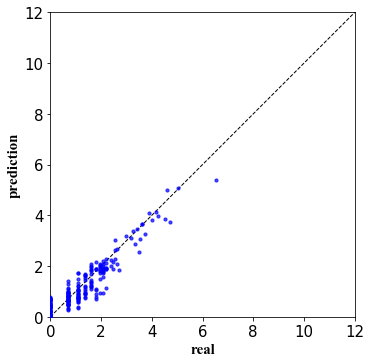

#########################################
test fold 1
预测误差较大城市:
潜江市   real: 1.791759469228055   pre:3.463943806010176
遵义市   real: 0.0   pre:1.7099602396173192
黔东南苗族侗族自治州   real: 0.0   pre:1.949985007128625
R-squared 0.6411321223414781
R 0.8007072638246003
mae 0.49596969110811384
rmse 0.6207860736718109


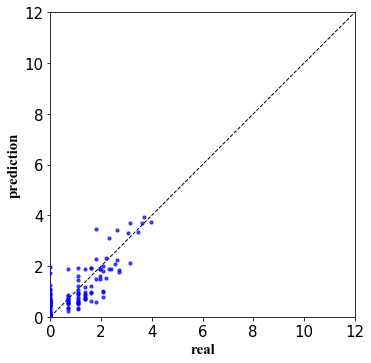

                             
train fold 2
预测误差较大城市:
武汉市   real: 6.54965074223381   pre:4.779684345328353
R-squared 0.8586699964358568
R 0.9266444822238229
mae 0.32671439154622967
rmse 0.4097359421373447


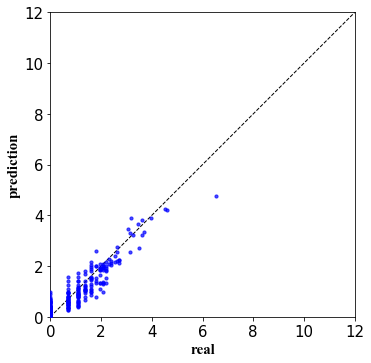

#########################################
test fold 2
预测误差较大城市:
铜川市   real: 1.791759469228055   pre:0.2875594332726339
R-squared 0.7401070401110662
R 0.8602947402553768
mae 0.5022900535065172
rmse 0.6132171980307847


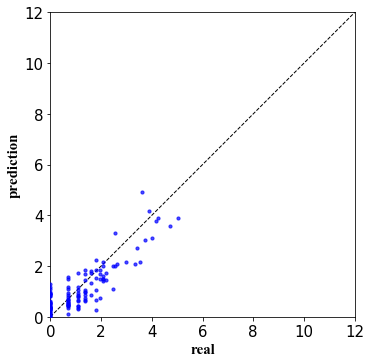

                             
train fold 3
预测误差较大城市:
R-squared 0.8781636215408702
R 0.9371038477889578
mae 0.3072187119102425
rmse 0.39115469601341374


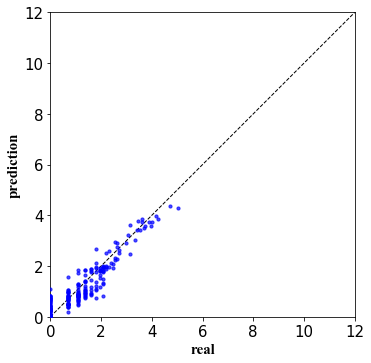

#########################################
test fold 3
预测误差较大城市:
德州市   real: 1.9459101490553132   pre:0.32963631092721846
武汉市   real: 6.54965074223381   pre:4.094916702214123
东莞市   real: 1.0986122886681098   pre:2.73200662689095
万宁市   real: 2.0794415416798357   pre:0.46437646266172267
R-squared 0.6563125795687935
R 0.8101312113286301
mae 0.49680449117470005
rmse 0.65398880064343


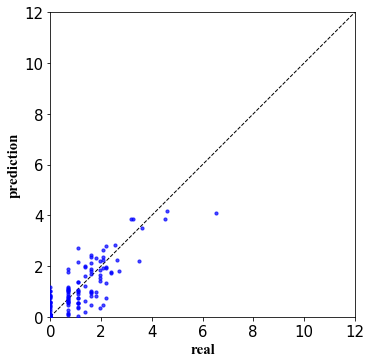

                             
************* cv evaluation ***************
R-squared 0.6793303963696852
R 0.8242150182869062
mae 0.49835902773296786
rmse 0.629511023500083


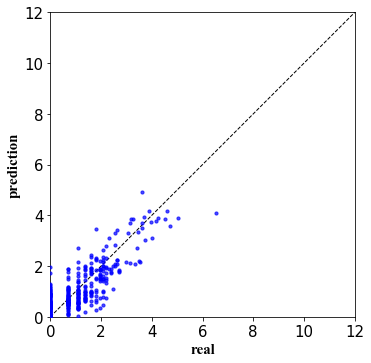

%%%%%%%%%%%%% all sample model %%%%%%%%%%%%%%
R-squared 0.8573490450907667
R 0.9259314472955148
mae 0.3366257606608744
rmse 0.4284180042943427


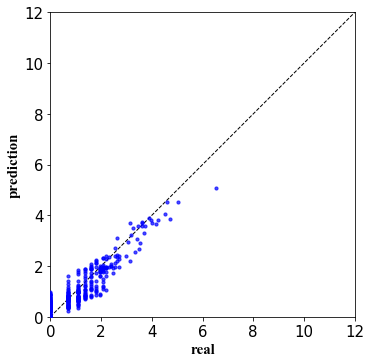

%%%%%% feature importances %%%%%%


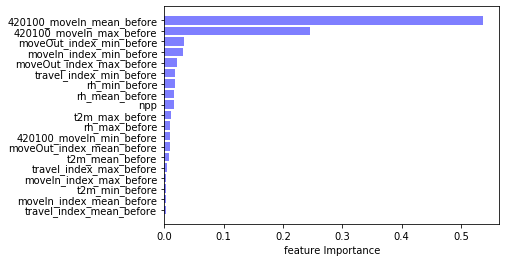

In [363]:
covid_all_predict(df2)

In [364]:
# 管控后疫情建模

In [366]:
df = pd.read_csv("../output/COVID_final.csv")

df2 = df[['id','location','npp',
         'rh_mean_after','rh_max_after','rh_min_after',
         't2m_mean_after','t2m_max_after','t2m_min_after',
         'moveIn_index_mean_after','moveIn_index_max_after',
         'moveIn_index_min_after','moveOut_index_mean_after',
         'moveOut_index_max_after','moveOut_index_min_after',
         'travel_index_mean_after','travel_index_max_after',
         'travel_index_min_after','420100_moveIn_mean_after',
         '420100_moveIn_max_after','420100_moveIn_min_after']]


confirmed = df['confirmed_after'].to_list()
confirmed = [math.log(i+1) for i in confirmed]
df2.loc[:, 'confirmed'] = confirmed
df2 = df2[~df2['id'].isin(['371200', '710000'])] # 去除台湾和莱芜

df2

/Users/shaoqi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/shaoqi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,location,npp,rh_mean_after,rh_max_after,rh_min_after,t2m_mean_after,t2m_max_after,t2m_min_after,moveIn_index_mean_after,...,moveOut_index_mean_after,moveOut_index_max_after,moveOut_index_min_after,travel_index_mean_after,travel_index_max_after,travel_index_min_after,420100_moveIn_mean_after,420100_moveIn_max_after,420100_moveIn_min_after,confirmed
0,110000,北京市,6.25382,46.468169,86.722396,17.081542,274.994719,284.989625,263.591917,2.905330,...,1.455727,5.303232,0.807311,2.520323,4.2272,1.3431,0.176,0.27,0.07,6.240276
1,120000,天津市,7.12393,46.642699,90.386729,10.992484,277.967881,288.570042,268.480167,1.487642,...,0.988932,2.005495,0.359802,3.023556,5.2505,1.4763,0.052,0.08,0.00,5.081404
2,130100,石家庄市,2.14262,50.901870,87.733075,19.951804,277.860148,288.740958,268.302292,1.033726,...,0.941177,1.774062,0.394826,3.126094,5.1806,1.7145,0.036,0.07,0.00,3.135494
3,130200,唐山市,2.67739,47.641678,93.551529,12.276571,276.620780,286.564375,265.588208,0.615503,...,0.580689,1.132153,0.200718,3.514908,5.3882,1.8941,0.010,0.03,0.00,0.000000
4,130300,秦皇岛市,1.50255,48.774308,89.614417,15.154958,275.195895,284.933333,262.464167,0.252586,...,0.258653,0.537484,0.081842,3.391455,5.0298,1.8130,0.000,0.00,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,659002,阿拉尔市,0.66720,39.473057,62.441879,19.870617,277.074868,288.034917,267.488333,0.028769,...,0.028908,0.081486,0.003110,2.134245,4.0822,0.5867,0.000,0.00,0.00,0.000000
359,659003,图木舒克市,1.20936,34.271311,62.464175,14.149744,279.226994,289.047417,270.137833,0.013298,...,0.014960,0.042217,0.001912,2.733564,4.9976,0.9690,0.000,0.00,0.00,0.000000
360,659004,五家渠市,3.26684,70.094339,101.004383,14.990040,269.775360,287.872083,253.920167,0.061538,...,0.059187,0.164009,0.015941,1.529576,3.1744,0.5857,0.000,0.00,0.00,0.000000
361,659005,北屯市,1.92770,71.213596,99.257154,30.104621,266.794566,280.935292,249.574333,0.029373,...,0.029247,0.138024,0.006383,2.183032,4.8881,0.4165,0.000,0.00,0.00,0.000000


train fold 1
预测误差较大城市:
鞍山市   real: 0.0   pre:1.8686320409703985
齐齐哈尔市   real: 3.7612001156935624   pre:2.150681072534476
蚌埠市   real: 5.062595033026967   pre:2.5354828377258176
亳州市   real: 4.634728988229636   pre:2.906430449655486
萍乡市   real: 3.4657359027997265   pre:0.9716142236505239
威海市   real: 3.4657359027997265   pre:1.7249344691227164
茂名市   real: 0.0   pre:1.6676673227275942
河源市   real: 0.0   pre:1.5007215964847394
甘孜藏族自治州   real: 4.343805421853684   pre:2.613481558593146
拉萨市   real: 0.0   pre:1.6165340269410855
榆林市   real: 0.0   pre:1.682844962854927
R-squared 0.8834422522324252
R 0.9399160878676486
mae 0.5428196171274602
rmse 0.7288710132860523


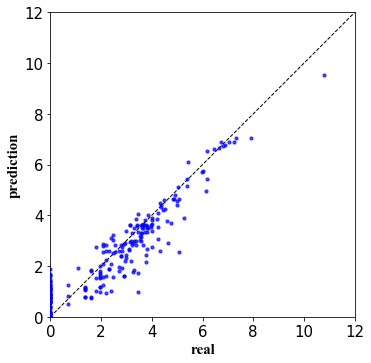

#########################################
test fold 1
预测误差较大城市:
北京市   real: 6.240275845170769   pre:4.475312703444243
唐山市   real: 0.0   pre:2.933597671371701
包头市   real: 2.302585092994046   pre:0.719349558335241
丹东市   real: 2.3978952727983707   pre:0.8338715195173613
双鸭山市   real: 3.9512437185814275   pre:0.11178263837913323
大庆市   real: 3.091042453358316   pre:1.4361725380462658
七台河市   real: 2.833213344056216   pre:0.01097733880735129
新余市   real: 4.852030263919617   pre:0.7885789152743683
济宁市   real: 5.545177444479562   pre:3.5572899559094906
焦作市   real: 0.0   pre:3.1475239024723374
神农架林区   real: 0.0   pre:4.57787654147614
中山市   real: 4.174387269895637   pre:2.5347469834960474
潮州市   real: 0.0   pre:3.279817889741927
防城港市   real: 2.833213344056216   pre:0.9632761362505716
临高县   real: 1.791759469228055   pre:0.2427514244751549
巴中市   real: 0.0   pre:2.623337841553494
毕节市   real: 0.0   pre:2.0786649017833208
玉溪市   real: 2.6390573296152584   pre:1.0381123277412636
天水市   real: 0.0   pre:2.108

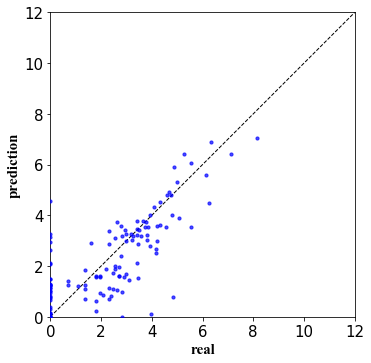

                             
train fold 2
预测误差较大城市:
鞍山市   real: 0.0   pre:1.5115720700283446
通化市   real: 0.0   pre:1.5591659963793376
双鸭山市   real: 3.9512437185814275   pre:2.0701665122190303
亳州市   real: 4.634728988229636   pre:2.9576788704567667
新余市   real: 4.852030263919617   pre:2.153286370541366
焦作市   real: 0.0   pre:2.273818110816222
神农架林区   real: 0.0   pre:3.615963597626421
茂名市   real: 0.0   pre:1.912816711666712
潮州市   real: 0.0   pre:2.10483599346103
贵港市   real: 0.0   pre:1.7761226118080233
巴中市   real: 0.0   pre:1.6197717692606404
甘孜藏族自治州   real: 4.343805421853684   pre:1.9778852144683658
昌吉回族自治州   real: 0.0   pre:1.6314564884632126
香港特别行政区   real: 0.0   pre:1.6033857085211118
R-squared 0.8524601576917582
R 0.9232876895593043
mae 0.5640288376119901
rmse 0.7770956794018195


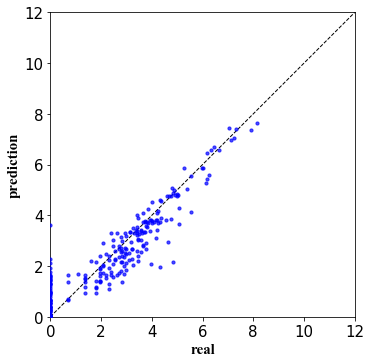

#########################################
test fold 2
预测误差较大城市:
鄂尔多斯市   real: 2.302585092994046   pre:0.48286507409355794
兴安盟   real: 0.0   pre:1.5991101399460241
葫芦岛市   real: 2.3978952727983707   pre:0.6816285405834719
延边朝鲜族自治州   real: 0.0   pre:1.6987645553346735
哈尔滨市   real: 5.25227342804663   pre:3.083195409277842
黑河市   real: 0.0   pre:2.185968176709799
淮北市   real: 3.295836866004329   pre:1.414740390197363
铜陵市   real: 3.295836866004329   pre:1.5445685242288607
莆田市   real: 4.02535169073515   pre:2.1245281034634305
宁德市   real: 3.1780538303479458   pre:1.6614324501280797
鹰潭市   real: 0.0   pre:1.8842297250833073
濮阳市   real: 0.0   pre:2.4464973831355694
武汉市   real: 10.805861899150436   pre:6.576305381888678
恩施土家族苗族自治州   real: 5.429345628954441   pre:7.107457827034248
娄底市   real: 4.248495242049359   pre:2.299815553382731
江门市   real: 0.0   pre:3.1301417064744603
河源市   real: 0.0   pre:2.168483781611175
钦州市   real: 0.0   pre:1.7478143946884974
贺州市   real: 0.0   pre:1.854325862701326
崇左市   r

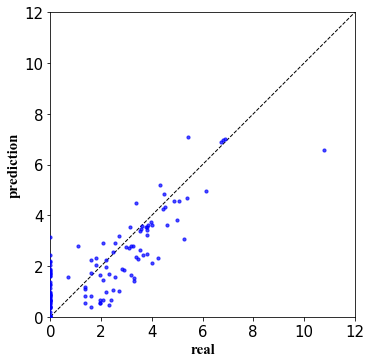

                             
train fold 3
预测误差较大城市:
张家口市   real: 0.0   pre:1.5846100558993417
锡林郭勒盟   real: 2.0794415416798357   pre:0.5190174800937555
双鸭山市   real: 3.9512437185814275   pre:2.028148883781684
新余市   real: 4.852030263919617   pre:1.826046235694402
济宁市   real: 5.545177444479562   pre:3.705435674463627
焦作市   real: 0.0   pre:1.7117993800591755
濮阳市   real: 0.0   pre:1.8525412514159378
武汉市   real: 10.805861899150436   pre:8.957191607787957
神农架林区   real: 0.0   pre:2.5168198484891566
娄底市   real: 4.248495242049359   pre:2.490700980553849
河源市   real: 0.0   pre:1.569245980284376
西双版纳傣族自治州   real: 2.70805020110221   pre:1.1501650352852573
R-squared 0.8688181947074507
R 0.932104175887787
mae 0.5544151189430899
rmse 0.74097118328591


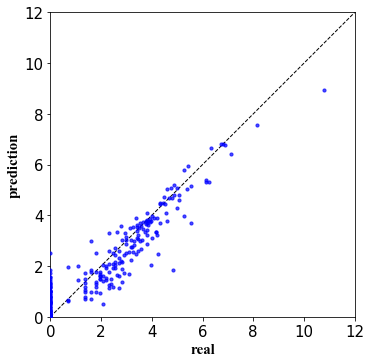

#########################################
test fold 3
预测误差较大城市:
呼和浩特市   real: 0.0   pre:2.9945795646242
鞍山市   real: 0.0   pre:2.388314163042907
锦州市   real: 0.0   pre:1.8429380784054168
齐齐哈尔市   real: 3.7612001156935624   pre:1.9847987944609056
温州市   real: 6.159095388491933   pre:4.300690957921213
蚌埠市   real: 5.062595033026967   pre:2.5988413246329367
亳州市   real: 4.634728988229636   pre:2.0891114022239927
萍乡市   real: 3.4657359027997265   pre:1.690974173415843
威海市   real: 3.4657359027997265   pre:1.9500297247955583
聊城市   real: 3.6375861597263857   pre:2.0367428968756385
茂名市   real: 0.0   pre:3.4510100106366735
河池市   real: 3.258096538021482   pre:1.0486201142145073
甘孜藏族自治州   real: 4.343805421853684   pre:0.017998061749886083
遵义市   real: 0.0   pre:2.127936925220808
宝鸡市   real: 0.0   pre:2.249154510402769
榆林市   real: 0.0   pre:1.6001440157066604
昌吉回族自治州   real: 0.0   pre:1.9978390353584128
伊犁哈萨克自治州   real: 2.8903717578961645   pre:0.4271649444648884
R-squared 0.704501763632026
R 0.8393460333

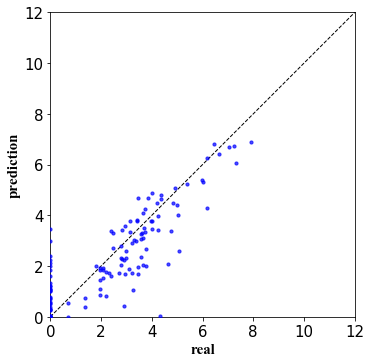

                             
************* cv evaluation ***************
R-squared 0.6572617960064401
R 0.8107168408306565
mae 0.892764108459478
rmse 1.187503866804793


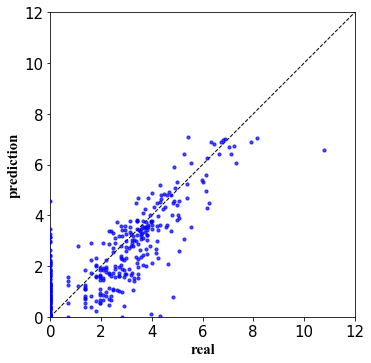

%%%%%%%%%%%%% all sample model %%%%%%%%%%%%%%
R-squared 0.8360463122662853
R 0.9143556814863051
mae 0.6307511097009826
rmse 0.8299922071195319


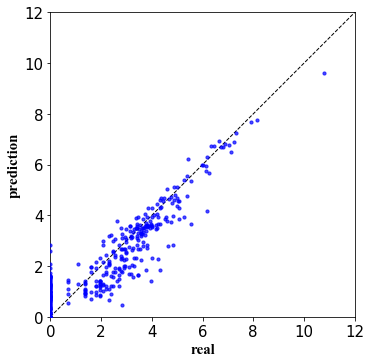

%%%%%% feature importances %%%%%%


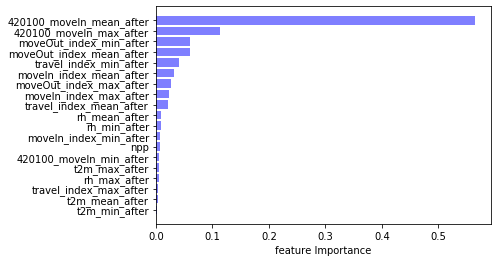

In [367]:
covid_all_predict(df2)